This notebook provides examples to go along with the [textbook](http://manipulation.csail.mit.edu/pose.html).  I recommend having both windows open, side-by-side!

In [2]:
import mpld3
import numpy as np
from matplotlib import pyplot as plt
from pydrake.all import DiagramBuilder, StartMeshcat

from manipulation import FindResource, running_as_notebook
from manipulation.scenarios import AddMultibodyTriad
from manipulation.station import AddPointClouds, LoadScenario, MakeHardwareStation
from manipulation.utils import RenderDiagram

if running_as_notebook:
    mpld3.enable_notebook()
    
meshcat = StartMeshcat()    

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Simulating an RGB-D camera



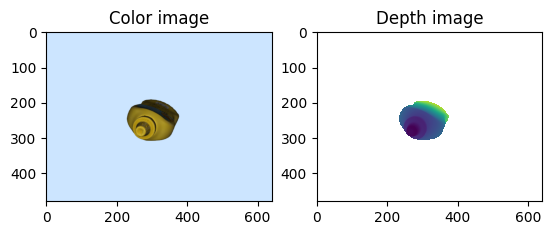

In [3]:
scenario_data = """
directives:
- add_model:
    name: mustard
    file: package://manipulation/hydro/006_mustard_bottle.sdf
- add_weld:
    parent: world
    child: mustard::base_link_mustard
    X_PC:
        translation: [0, 0, 0.09515]
        rotation: !Rpy { deg: [-90, 0, -90]}
- add_model:
    name: camera
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: world
    child: camera::base
    X_PC:
        translation: [0.5, 0.1, 0.2]
        # Point slightly down towards camera
        # RollPitchYaw(0, -0.2, 0.2) @ RollPitchYaw(-np.pi/2, 0, np.pi/2)
        rotation: !Rpy { deg: [-100, 0, 100] }
cameras:
    main_camera:
        name: camera0
        depth: True
        X_PB:
            base_frame: camera::base
"""


def DepthCameraDemoSystem():
    builder = DiagramBuilder()

    scenario = LoadScenario(data=scenario_data)
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat))

    # Export the camera outputs
    builder.ExportOutput(station.GetOutputPort("camera0.rgb_image"), "rgb_image")
    builder.ExportOutput(station.GetOutputPort("camera0.depth_image"), "depth_image")

    to_point_cloud = AddPointClouds(
        scenario=scenario, station=station, builder=builder, meshcat=meshcat
    )

    # Add a box for the camera in the environment.
    plant = station.GetSubsystemByName("plant")
    camera_instance = plant.GetModelInstanceByName("camera")
    scene_graph = station.GetSubsystemByName("scene_graph")
    AddMultibodyTriad(
        plant.GetFrameByName("base", camera_instance),
        scene_graph,
        length=0.1,
        radius=0.005,
    )

    # Export the point cloud output.
    builder.ExportOutput(
        to_point_cloud["camera0"].point_cloud_output_port(), "point_cloud"
    )

    diagram = builder.Build()
    diagram.set_name("depth_camera_demo_system")
    return diagram


def plot_camera_images():
    system = DepthCameraDemoSystem()

    # Evaluate the camera output ports to get the images.
    context = system.CreateDefaultContext()
    system.ForcedPublish(context)
    color_image = system.GetOutputPort("rgb_image").Eval(context)
    depth_image = system.GetOutputPort("depth_image").Eval(context)

    # Plot the two images.
    plt.subplot(121)
    plt.imshow(color_image.data)
    plt.title("Color image")
    plt.subplot(122)
    plt.imshow(np.squeeze(depth_image.data))
    plt.title("Depth image")
    # mpld3.display()
    plt.show()


plot_camera_images()

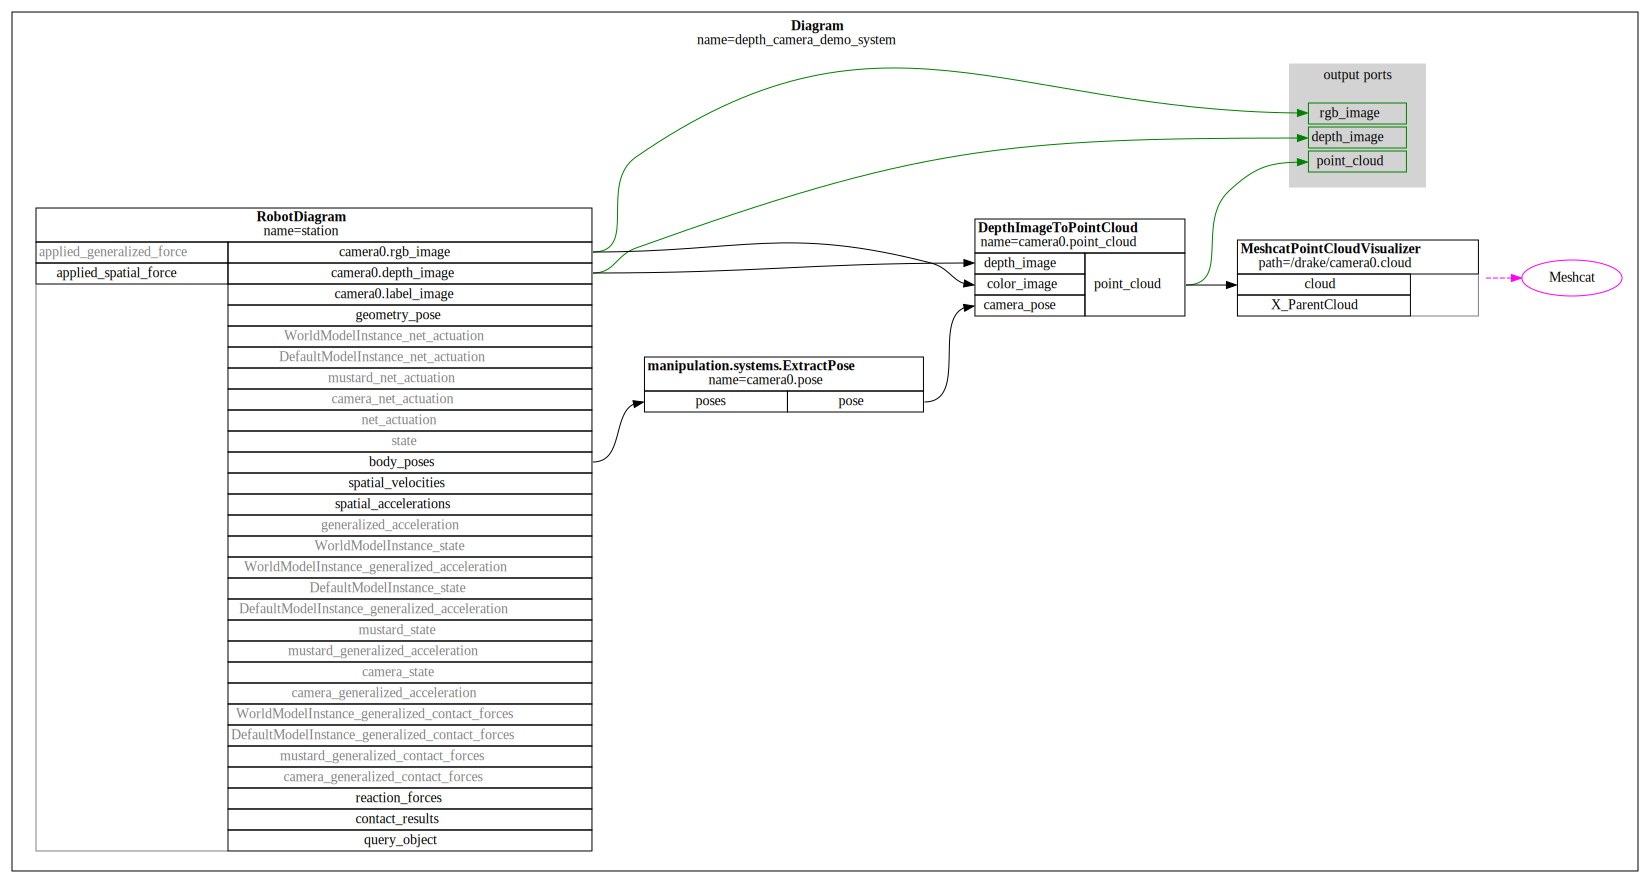

In [8]:
RenderDiagram(DepthCameraDemoSystem(), max_depth=2)

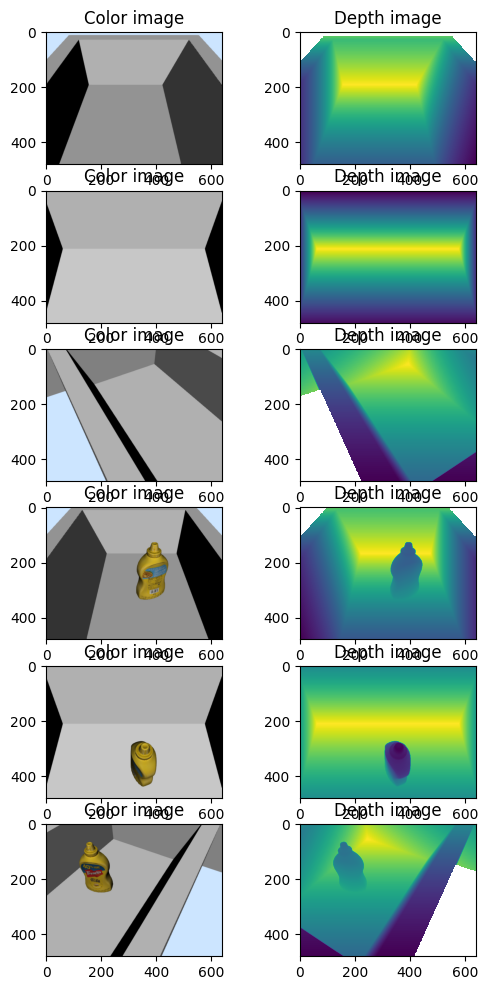

In [4]:
def plot_manipulation_station_camera_images():
    scenario = LoadScenario(
        filename=FindResource("models/clutter.scenarios.yaml"),
        scenario_name="Mustard",
    )
    station = MakeHardwareStation(scenario, meshcat)

    context = station.CreateDefaultContext()

    index = 1
    plt.figure(figsize=(6, 12))
    for camera_num in range(6):
        color_image = station.GetOutputPort(f"camera{camera_num}.rgb_image").Eval(
            context
        )
        depth_image = station.GetOutputPort(f"camera{camera_num}.depth_image").Eval(
            context
        )

        plt.subplot(6, 2, index)
        plt.imshow(color_image.data)
        index += 1
        plt.title("Color image")
        plt.subplot(6, 2, index)
        plt.imshow(np.squeeze(depth_image.data))
        index += 1
        plt.title("Depth image")

    plt.show()


plot_manipulation_station_camera_images()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d52c94f9-ddc1-424b-9ff7-4039617d465d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>